In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Učitavanje videa
cap = cv2.VideoCapture("Kocka_Vid1.mp4")


In [5]:
# Funkcija za detekciju boje polja
def detect_color(tile):
    avg_color = tile.mean(axis=0).mean(axis=0)
    return avg_color


# Funkcija za provjeru preklapanja čelija kontura
def is_overlapping(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    return not (x1 > x2 + w2 or x2 > x1 + w1 or y1 > y2 + h2 or y2 > y1 + h1)

# Funkcija za filtriranje čelija kontura koje se preklapaju 
def filter_overlapping_contours(contours):
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    filtered_contours = []
    
    for i, box1 in enumerate(bounding_boxes):
        keep = True
        for j, box2 in enumerate(bounding_boxes):
            if i != j and is_overlapping(box1, box2):
                if cv2.contourArea(contours[i]) < cv2.contourArea(contours[j]):
                    keep = False
                    break
        if keep:
            filtered_contours.append(contours[i])
    
    return filtered_contours


# Preset boje Rubikove kocke (RGB)
preset_colors_rgb = {
    'white': [255, 255, 255],
    'yellow': [175, 200, 10],
    'red': [255, 0, 0],
    'orange': [200, 100, 10],
    'green': [0, 255, 0],
    'blue': [0, 0, 255]
}

# Funkcija za usporedbu i postavljanje detektirane boje s preset bojama  
def closest_color(color, preset_colors):
    min_distance = float('inf')
    closest_color_name = None
    for name, preset_color in preset_colors.items():
        distance = np.linalg.norm(color - preset_color)
        if color[0] > 160 and color[1] < 60:
            closest_color_name = 'red'
            
        elif distance < min_distance:
            min_distance = distance
            closest_color_name = name
            
    return closest_color_name


# Funkcija za obradu slika (Frame-a) i detekciju boja
def process_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, threshold1=20, threshold2=25)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cube_contours = []
    for contour in contours:
        epsilon = 0.15 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            cube_contours.append(approx)
    
    cube_contours = filter_overlapping_contours(cube_contours)
    
    tiles = []
    colors = []
    positions = []
    for contour in cube_contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 50 and h > 50:
            tile = frame[y:y+h, x:x+w]
            tiles.append(tile)
            color = detect_color(tile)
            colors.append(color)
            positions.append((x, y, w, h))
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Sortiranje polja po vertikali-y (gore prema dolje)
    positions_colors = sorted(zip(positions, colors), key=lambda b: b[0][1])

    # Dijeljenje u redove (uzimajuči 3x3 raspored)
    rows = [positions_colors[i:i+3] for i in range(0, len(positions_colors), 3)]

    # Sortiranje svakog reda po horizontali-x (lijevo prema desno)
    sorted_positions_colors = [sorted(row, key=lambda b: b[0][0]) for row in rows]

    # Spajanje sortiranih redova u jednu listu
    sorted_positions_colors = [color for row in sorted_positions_colors for _, color in row]
    
    # Pretvorba detektiranih BGR boja u RGB
    colors_rgb = [cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_BGR2RGB)[0][0] for color in sorted_positions_colors]

    # Postavljanje detektirane boje s najbližom preset bojom
    closest_colors = [preset_colors_rgb[closest_color(color, preset_colors_rgb)] for color in colors_rgb]
    
    return frame, closest_colors


Side 1 captured.
Side 2 captured.
Side 3 captured.
Side 4 captured.
Side 5 captured.
Side 6 captured.


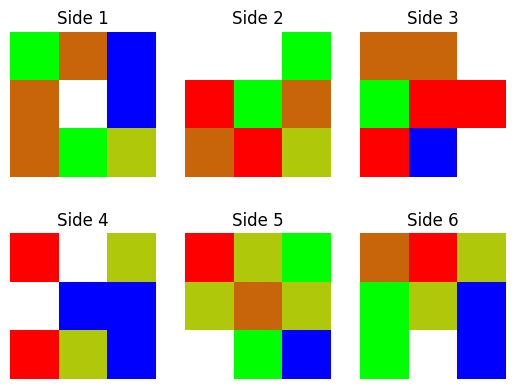

In [6]:
# Varijabla za spremanje boja svake stranice
sides_colors = []
center_colors = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (360, 640))

    processed_frame, closest_colors = process_frame(frame)
    
    cv2.imshow('Processed Frame', processed_frame)
    
    if len(closest_colors) == 9:
        # Check if this side has already been captured by comparing center tile colors
        center_color = closest_colors[4]
        if all(np.linalg.norm(center_color - np.array(c)) > 10 for c in center_colors):
            sides_colors.append(closest_colors)
            center_colors.append(center_color)
            print(f'Side {len(sides_colors)} captured.')

            if len(sides_colors) == 6:
                break
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Spajanje i prikazivanje svih stranica
if len(sides_colors) == 6:
    for i, side_colors in enumerate(sides_colors):
        color_grid = np.array(side_colors).reshape(3, 3, 3) / 255.0
        plt.subplot(2, 3, i+1)
        plt.imshow(color_grid)
        plt.axis('off')
        plt.title(f'Side {i+1}')
    plt.show()
else:
    print("Not all sides were captured.")
